# Data Processing

## Remove Rows and Sample Randomly

We will now drop any rows that are irrelevant to us and save it to a CSV file.

In [19]:
import pandas as pd

df = pd.read_csv('data/Books_rating.csv')

# preserve relevant columns and rename for ease of access
df = df[['review/summary', 'review/text', 'review/score']]
df.columns = ['summary', 'text', 'score']

# sample a portion of the data
n = 250000
df = df.sample(n=n, random_state=1)

# save to new csv file and view data
df.to_csv('data/Books_rating_relevant_columns.csv', index=False)
df.head()

,summary,text,score
2896109,Best edition of this classic.,I've always recommended this Yale edition of F...,5.0
2381153,Great Book!!,This is required reading for my 16 yr old son....,5.0
1028690,Not just a book for consultant,"Plain-spoken, finished the book only has taken...",4.0
1945977,Outrageously Bad,Wow... this is one of the most ridiculous stor...,1.0
2812693,Cunning and determination,A crew has mutinied and threatens to hang thei...,4.0


## Stopwords, Lemmatization, and Vectorization

Process the text to remove stopwords, lemmatize, strip unneeded characters, then vectorize.

In [20]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm

tqdm.pandas()

In [21]:
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))


def stemmer(text):
    if text != text:
        return ''

    # clean the text
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.lower()

    # tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if not w in stopwords]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    text = ' '.join(tokens)

    return text

In [22]:
df = pd.read_csv('data/Books_rating_relevant_columns.csv')

# apply stemmer to text
df['stemmed_text'] = df['text'].progress_apply(stemmer)
df['stemmed_summary'] = df['summary'].progress_apply(stemmer)
df['stemmed_summary_text'] = df['stemmed_summary'] + ' ' + df['stemmed_text']

# remove trailing spaces
df['stemmed_summary_text'] = df['stemmed_summary_text'].progress_apply(
    lambda x: x.strip())

# clean up NaN and remove empty rows
df.fillna('', inplace=True)
df = df[df['stemmed_summary_text'] != '']

# drop unused columns
df.drop(columns=['text', 'summary', 'stemmed_summary',
        'stemmed_text'], inplace=True)

# save to new csv file and view the data
df.to_csv('data/Books_rating_stemmed.csv', index=False)
df.head()

 43%|████▎     | 108315/250000 [00:49<01:04, 2180.87it/s]


KeyboardInterrupt: 

## Vectorizing

Vectorize the text using TF-IDF.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle

tqdm.pandas()

In [ ]:
df = pd.read_csv('data/Books_rating_stemmed.csv')
print(f'Shape of dataframe: {df.shape}')

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['stemmed_summary_text'], df['score'], test_size=0.2, random_state=1)

# init the vectorizer and fit on the training set
vectorizer = TfidfVectorizer(max_features=30_000, sublinear_tf=True)
vectorizer.fit(X_train)

# transform training and test sets
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# get shape of training and test sets
print(f'Shape of training set: {X_train.shape}')
print(f'Shape of testing set: {X_test.shape}')

# save vectorizer to disk
pickle.dump(vectorizer, open('models/vectorizer.pkl', 'wb'))
print('Vectorizer saved!')

Shape of dataframe: (250000, 2)
Shape of training set: (200000, 30000)
Shape of testing set: (50000, 30000)
Vectorizer saved!


## Model Testing

Test the model using a variety of classifiers and hyperparameters.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:

def test_model(model, param_grid, model_name):
    grid_search = GridSearchCV(
        model, param_grid, cv=2, scoring='accuracy', n_jobs=-1
    )  # use a smaller number of folds for faster testing
    grid_search.fit(X_train, y_train)

    # get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # test the best model
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print('Model:', model_name)
    print('-' * 30)
    print('Best Parameters:', best_params)
    print('Accuracy:', accuracy)
    print('MSE:', mse)
    print('RMSE:', rmse)

    # plot the performance per epoch
    epochs = [i for i in range(len(grid_search.cv_results_['mean_test_score']))]
    accuracy_per_epoch = grid_search.cv_results_['mean_test_score']

    plt.plot(epochs, accuracy_per_epoch, label=model_name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # save the plot to disk
    plt.savefig(f'plots/{model_name}_performance.png')
    plt.show()

Model: Naive Bayes
------------------------------
Best Parameters: {'alpha': 0.1}
Accuracy: 0.62978
MSE: 1.62038
RMSE: 1.2729414754811


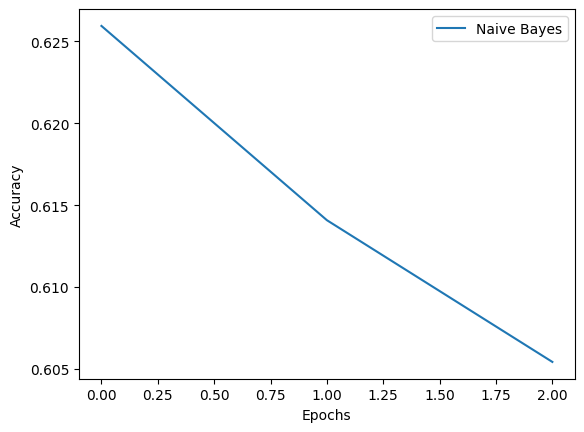

KeyboardInterrupt: 

In [ ]:
# define models and their hyperparameter grids
models = {
    'Naive Bayes': {
        'model': MultinomialNB(),
        'param_grid': {'alpha': [0.1, 0.5, 1.0]},
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, n_jobs=-1, solver='saga'),
        'param_grid': {'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2']},
    },
    'Support Vector Machine': {
        'model': LinearSVC(max_iter=1000),
        'param_grid': {'C': [0.1, 1.0, 10.0]},
    },
    'Random Forest': {
        'model': RandomForestClassifier(n_jobs=-1),
        'param_grid': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'param_grid': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    },
}

for model_name, model_info in models.items():
    model = model_info['model']
    param_grid = model_info['param_grid']

    # test the model and plot the performance
    test_model(model, param_grid, model_name)

# show the plot
plt.show()